# Twitter user gender classification


In [2]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Dropout, Activation

import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## question 1
In this question we've preprocessed the data in our csv file and analyzed the given data.
We've printed out plots which indicates what are the most commonly used terms and hashtags used by the two opposite genders.

In [3]:
# Reading the data from the file
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = 'latin1') #iso-8859-1

In [4]:
# This is the metadata of our training experiment.
# We can see what are our
print(data_df.axes)

[RangeIndex(start=0, stop=20050, step=1), Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')]


In [5]:
def clean(words_string):
    '''
    Returns a string after removing stop words and punctuations, lowering all characters and normalizing the words.
    '''
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    stop_free=" ".join([i for i in words_string.lower().split() if i not in stop])
    punc_free=''.join(ch if ch not in exclude else ' ' for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

def uniteLists(list_of_lists_of_words):
    '''
    Doing flat reduce, returning only one list of strings 
    '''
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    '''
    Returns all the terms and their frequencies in the given list.
    '''
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq
def createPlot(x_data,y_data,y_name,x_name,title,i,j,k,color,bartype):
    '''
    Prints a plot for the given inputs:
    x_data - an array for the x axes.
    y_data - an array for the y axes.
    y_name - the label for the y axes.
    x_name - the label for the x axes.
    title - title for the plot.
    i,j,k,color,bartype - some data for the decoration of the graph.
    '''
    axis_font = {'family': 'serif','color':  'black','weight': 'normal','size': 18,}
    title_font = {'family': 'serif','color':  'black','weight': 'normal','size': 22,}
    font_size=16
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_data)
    temp.sort_values(by=(y_name), ascending=True,inplace=True)
    ax = fig.add_subplot(i,j,k) #121
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    ax.set_xlabel(x_name,fontdict=axis_font)
    ax.set_ylabel(y_name,fontdict=axis_font)
    ax.set_title(title,fontdict=title_font)
    temp.plot(kind=bartype,ax=ax,cmap=color)

### cleaning the data

- **'text'**- sentence per user cleaned from http links and garbage letters.
- **'hashtag'**- list of #hashtags per user.
- **'user_tag'** - list of @user_tags per user.
- **'clean_text'**- same as 'text' just without #tags and @tags.
- **'clean_words_list'**- same as 'clean_text' just splitted to list of words per user.

In [6]:
def extractCleanedDataFromTweets(data_df):
    data_df = data_df[data_df['gender'].apply(lambda x : (x=='male' or x=='female') )]
    data_df['text']=data_df['text'].apply(lambda x :  re.sub('(htt\S+)',"",x))
    data_df['text']=data_df['text'].apply(lambda x :  re.sub('[^a-zA-Z0-9 #@]+',"",x))
    data_df['hashtags']=data_df['text'].apply(lambda x :  re.findall('#[a-zA-Z]+',x))
    data_df['user_tag']=data_df['text'].apply(lambda x :  re.findall('@[a-zA-Z]+',x))
    data_df['clean_text']=data_df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
    data_df['clean_text']=data_df['clean_text'].apply(clean)
    data_df['clean_words_list']=data_df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))
    return data_df

### male/female_tf contains all the terms with their frequencies. 

In [7]:
def getTfByGender(data_df, gender):
    gender_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(gender_words).most_common()

### plot of the number of most common terms for male and female

C:\Users\aviv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aviv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\aviv\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

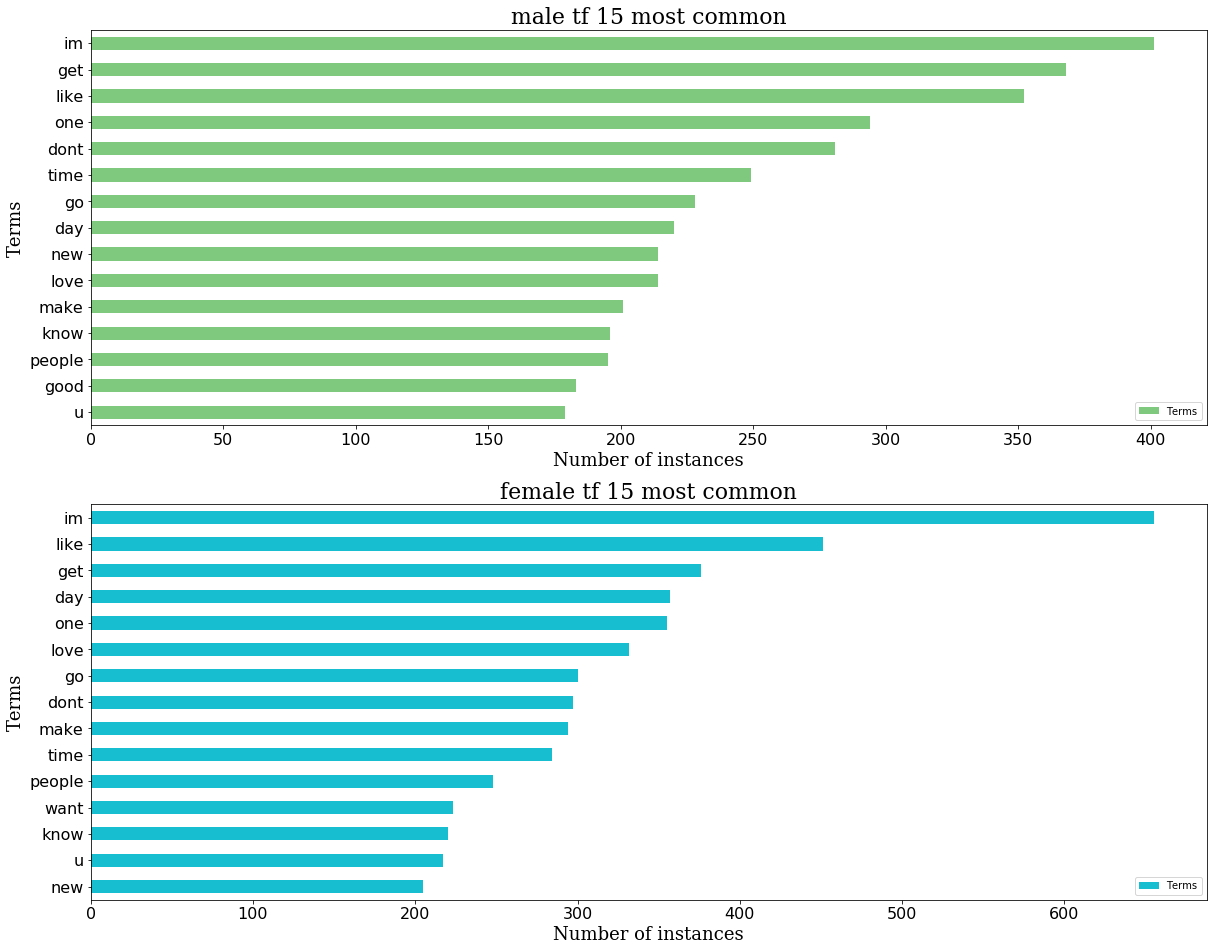

In [8]:
pd.options.mode.chained_assignment
data_df = extractCleanedDataFromTweets(data_df)
male_tf = getTfByGender(data_df, 'male')
female_tf = getTfByGender(data_df, 'female')

num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### male/female_hashtag_tf contains all the hashtags with their frequencies. 


In [9]:
def getHashtagsByGender(data_df, gender):
    hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x==gender)])
    return Counter(hashtag_words).most_common()

### plot for num most common #hashtags

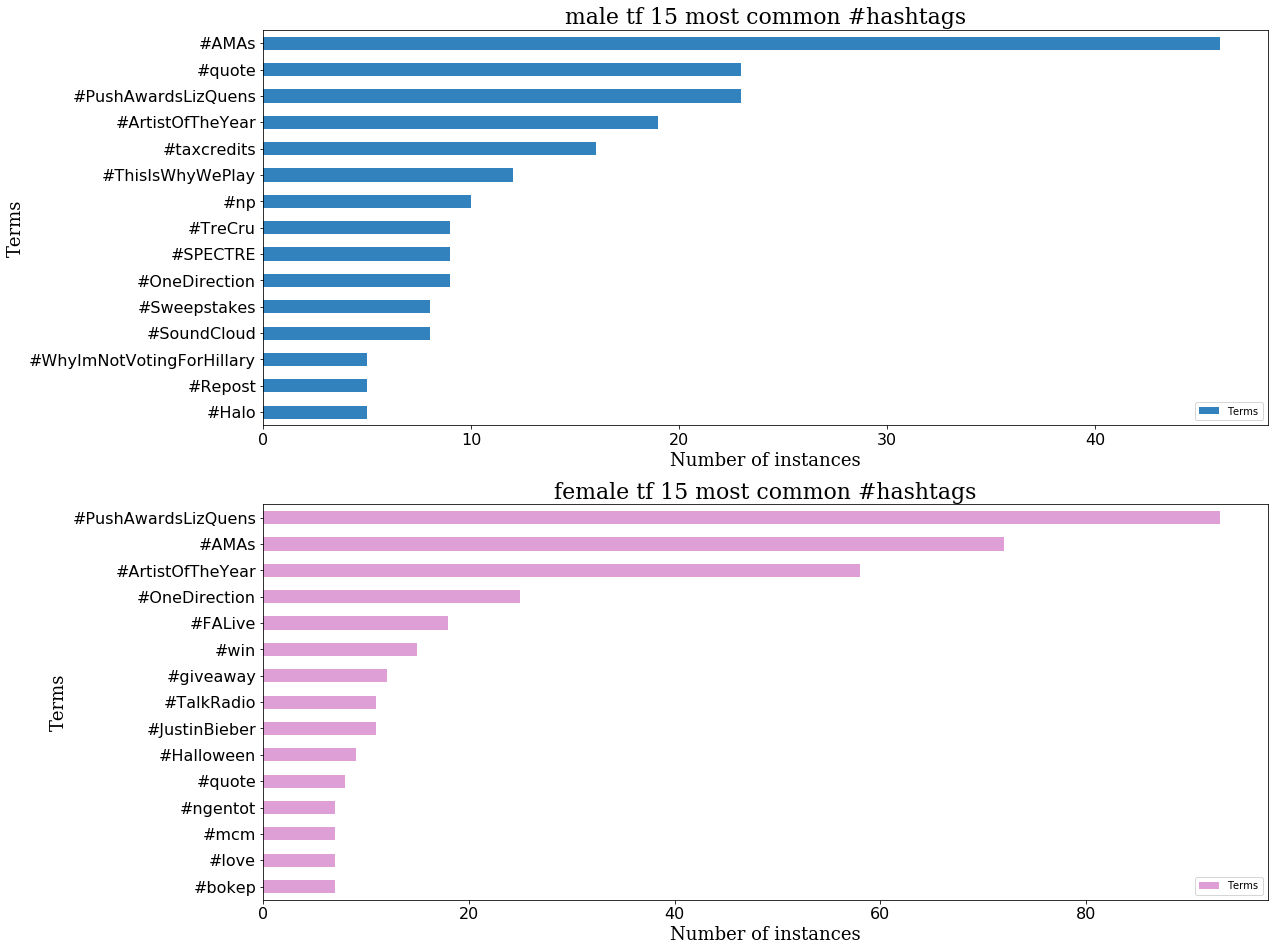

In [10]:
male_hashtag_tf = getHashtagsByGender(data_df, 'male')
female_hashtag_tf = getHashtagsByGender(data_df, 'female')

num=15
fig = plt.figure(figsize=(18,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

## Question 2

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [12]:
corpus=data_df['text'].tolist()[:500]
X = vectorizer.fit_transform(corpus)

In [13]:
def changeGenderToNum(word):
    if word=='male':
        return 1 
    return 0
def changeNumToGender(num):
    if num==0:
        return 'female' 
    return 'male'
data_df['num_gender']=data_df['gender'].apply(changeGenderToNum)
Y=data_df['num_gender'][:500].tolist()

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

def benchmark(clf,X_train,y_train):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    X_test=X_train
    y_test=y_train
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []

# from keras.utils import to_categorical
# y_binary = to_categorical(Y)

#DLmodel = Sequential()
#DLmodel.add(Dense(500,input_shape=(2593,), activation='relu'))
#DLmodel.add(Dropout(0.5))
#DLmodel.add(Dense(256, activation='sigmoid'))
#DLmodel.add(Dropout(0.5))
# DLmodel.add(Dense(0, activation='softmax'))
# DLmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

# DLmodel.fit(X, y=y_binary, batch_size=2593, nb_epoch=10, verbose=1, validation_split=0.2)


# DLmodel.add(Embedding(input_dim=X.shape[0],output_dim= 500, input_length=X.shape[1]))
# DLmodel.add(Flatten())
# DLmodel.add(Dense(200, activation='sigmoid'))
# DLmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])
# DLmodel.fit(X, y=Y, batch_size=200, nb_epoch=10, verbose=1, validation_split=0.2)
# scores = model.evaluate(X, Y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
SVM=SGDClassifier()
PER=Perceptron()
NB=MultinomialNB()
KN=KNeighborsClassifier(15)
for clf, name in (
        (SVM,"SVM"),
        (KN, "kneighbors"),
        (NB,"Naive Bayes")
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf,X,Y))


SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.009s
test time:  0.001s
accuracy:   0.970

kneighbors
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
train time: 0.002s
test time:  0.047s
accuracy:   0.572

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.007s
test time:  0.00

C:\Users\aviv\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [15]:
changeNumToGender(SVM.predict(vectorizer.transform(['there is a football game this monday']).toarray())[0])

'male'

## Question 3

## Get most tweeted country
We've tried to find which country has the biggest number of tweets in our datasets,
as we can see, combining all the tweets from all the states of USA reveals that it is the most tweeted country.

In [16]:
locations = data_df['tweet_location'][data_df['tweet_location'].apply(lambda x: type(x) == str)]
locations=locations.apply(clean)
locations_tf = Counter(locations).most_common()
locations_tf

[('london', 120),
 ('los angeles ca', 57),
 ('uk', 53),
 ('united state', 50),
 ('los angeles', 46),
 ('new york', 41),
 ('lagos nigeria', 38),
 ('london england', 36),
 ('', 36),
 ('nyc', 34),
 ('chicago il', 33),
 ('atlanta ga', 33),
 ('usa', 32),
 ('texas', 32),
 ('california', 32),
 ('boston', 31),
 ('canada', 31),
 ('new york ny', 30),
 ('chicago', 30),
 ('united kingdom', 29),
 ('washington dc', 28),
 ('houston tx', 26),
 ('austin tx', 26),
 ('england', 25),
 ('toronto', 25),
 ('san francisco ca', 21),
 ('england united kingdom', 21),
 ('manchester', 20),
 ('philadelphia pa', 20),
 ('florida', 19),
 ('\x89ã\x8farry laura \x88â»\x88âò', 19),
 ('scotland', 18),
 ('new york city', 18),
 ('ohio', 17),
 ('seattle wa', 17),
 ('atlanta', 16),
 ('nigeria', 15),
 ('earth', 15),
 ('brooklyn ny', 15),
 ('seattle', 15),
 ('glasgow', 14),
 ('charlotte nc', 14),
 ('italy', 14),
 ('michigan', 14),
 ('houston', 14),
 ('denver co', 14),
 ('ireland', 13),
 ('lagos', 13),
 ('birmingham', 13),
 ('lo

In [17]:
# Parameters and functionality initialization for our interaction with twitter api

consumer_key = 'aZgjP0NZeM4iiBaQXJcyOKLJB'
consumer_secret = 'VRLyop5JLP8Kh91CMnE0rpOKUhKEtrrVTCOozHVOd8QEFx69XX'
access_token = '326266960-9RZItG8Q4FUER0BOX4eO8mrvsvrrDWzaWiJqoens'
access_secret = 'v6UHn9puTUv5OgcDwGqf3UxfCZv6XSJZ1gB8UkXOFrnQo'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

In [49]:
JSON_MALE_FILE_NAME='male_tweets.json'
JSON_FEMALE_FILE_NAME='female_tweets.json'
MAX_NUMBER_OF_TWEETS = 219
MALE_FILTER_HASHTAG = '#nba'
FEMALE_FILTER_HASHTAG = '#femalefilmmakerfriday'

class MyListener(StreamListener):
    def __init__(self, jsonFileName):
        self.jsonFileName = jsonFileName
        self.f = open(jsonFileName, 'w')
        self.f.write('[')
        self.tweets_gathered = 0
    
    def on_data(self, data):
    #def on_status(self, status):
        #global tweets_gathered
        if MAX_NUMBER_OF_TWEETS > self.tweets_gathered:
            self.tweets_gathered += 1
            try:
                print(self.tweets_gathered)
                self.f.write(data.rstrip() + ',')
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            self.f.seek
            return False
    def on_error(self, status):
        print("Error" + status)
        return True
    def __del__(self):
        self.f.close()
        #just a fix to the json file
        with open(self.jsonFileName, 'rb+') as self.f:
            self.f.seek(-1, os.SEEK_END)
            self.f.write(b']')    
        print('died')
    def on_exception(self, exception):
        print(exception)

def generateTweets(isMalesGender):
    if isMalesGender:
        jsonFileName = JSON_MALE_FILE_NAME
        filterHashtags = MALE_FILTER_HASHTAG
    else:
        jsonFileName = JSON_FEMALE_FILE_NAME
        filterHashtags = FEMALE_FILTER_HASHTAG
    myList = MyListener(jsonFileName)
    twitter_stream = Stream(auth, myList)
    # I think Asi said she gives up on the location part because students told her it is somewhat problematic with the other fiter.
    # those coordinates are boxed that represents most of america - the country that we've found to have the most tweetings. 
    #twitter_stream.filter(locations=[-124.89,32.7,-93.07,48.99,
    #                                 -110.64,31.98,-84.43,47.01,
    #                                -99.04,26.29,-72.83,41.58,
    #                                -79.0,32.1,-70.6,43.69,
    #                                -75.3,41.06,-66.91,45.06])
    twitter_stream.filter(track=[filterHashtags])
     
# From here we generate the two json files, one for males a
#generateTweets(True)
#generateTweets(False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
died


In [53]:
new_twitts_male_df = pd.read_json(path_or_buf=JSON_MALE_FILE_NAME)
new_twitts_female_df = pd.read_json(path_or_buf=JSON_FEMALE_FILE_NAME)
new_twitts_male_df['gender'] = 'male'
new_twitts_female_df['gender'] = 'female'

new_twitts_df = new_twitts_male_df.append(new_twitts_female_df, ignore_index = True)

In [54]:
new_twitts_df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,gender
0,NaN,NaN,2018-02-23 21:10:36,NaN,"{'hashtags': [{'text': 'nba', 'indices': [14, ...",NaN,"{'full_text': 'Season prices #nba $15, #nhl $...",0,False,low,NaN,967144685889351682,967144685889351680,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Season prices #nba $15, #nhl $12, #soccer $12...",2018-02-23 21:10:36.452,True,"{'id': 725408779664285696, 'id_str': '72540877...",male
1,NaN,NaN,2018-02-23 21:10:38,NaN,"{'hashtags': [{'text': 'NBA', 'indices': [96, ...",NaN,NaN,0,False,low,NaN,967144695989141511,967144695989141504,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 07:02:48 +0000 2018...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @WorldEliteSyn: Friday is UP !!\n\n*VIP*\n5...,2018-02-23 21:10:38.860,False,"{'id': 967142496982700036, 'id_str': '96714249...",male
2,NaN,NaN,2018-02-23 21:10:48,"[31, 140]","{'hashtags': [{'text': 'BHM', 'indices': [31, ...",NaN,{'full_text': '@TheNBPA @celtics @KyrieIrving ...,0,False,low,NaN,967144735298244608,967144735298244608,TheNBPA,9.670541e+17,9.670541e+17,1.169007e+08,1.169007e+08,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@TheNBPA @celtics @KyrieIrving #BHM #NBA #NBPA...,2018-02-23 21:10:48.232,True,"{'id': 753187516887527424, 'id_str': '75318751...",male
3,NaN,NaN,2018-02-23 21:10:53,NaN,"{'hashtags': [{'text': 'FreePick', 'indices': ...",NaN,NaN,0,False,low,NaN,967144755648978949,967144755648978944,None,NaN,NaN,NaN,NaN,False,pt,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:03:14 +0000 2018...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @EnsaDeportiva: #FreePick #Directas #NBA\n\...,2018-02-23 21:10:53.084,False,"{'id': 2652514767, 'id_str': '2652514767', 'na...",male
4,NaN,NaN,2018-02-23 21:10:57,NaN,"{'hashtags': [{'text': 'NASCAR', 'indices': [1...",NaN,NaN,0,False,low,NaN,967144775341170688,967144775341170688,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:08:05 +0000 2018...,"<a href=""http://twitter.com/download/android"" ...",RT @JerseyKidPicks: Sign-ups all safe and secu...,2018-02-23 21:10:57.779,False,"{'id': 713226793340116992, 'id_str': '71322679...",male
5,NaN,NaN,2018-02-23 21:11:06,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,NaN,967144810485182464,967144810485182464,None,NaN,NaN,NaN,NaN,False,en,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:05:04 +0000 2018...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @VegasPropKing: First day back from the all...,2018-02-23 21:11:06.158,False,"{'id': 2883953113, 'id_str': '2883953113', 'na...",male
6,NaN,NaN,2018-02-23 21:11:19,"[0, 79]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,low,NaN,967144866097614848,967144866097614848,None,NaN,NaN,NaN,NaN,True,en,None,0.0,0,{'created_at': 'Fri Feb 23 02:56:02 +0000 2018...,9.668692e+17,9.668692e+17,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",SHE WAS DRUNK ON LIBERALISM! WHAT A UGLY FREAK...,2018-02-23 21:11:19.417,False,"{'id': 1594430870, 'id_str': '1594430870', 'na...",male
7,NaN,NaN,2018-02-23 21:11:20,NaN,"{'hashtags': [{'text': 'Picks', 'indices': [30...",NaN,NaN,0,False,low,NaN,967144871961268224,967144871961268224,None,NaN,NaN,NaN,NaN,False,pt,None,NaN,0,NaN,NaN,NaN,0,0,False,{'created_at': 'Fri Feb 23 21:02:27 +0000 2018...,"<a href=""http://twi

In [55]:
# fixes all the places part of the tweet was missing
for i in range(0, new_twitts_df.shape[0]):
    if pd.notnull(new_twitts_df.loc[i,'extended_tweet']):
        new_twitts_df['text'][i] = new_twitts_df['extended_tweet'][i]['full_text']

C:\Users\aviv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


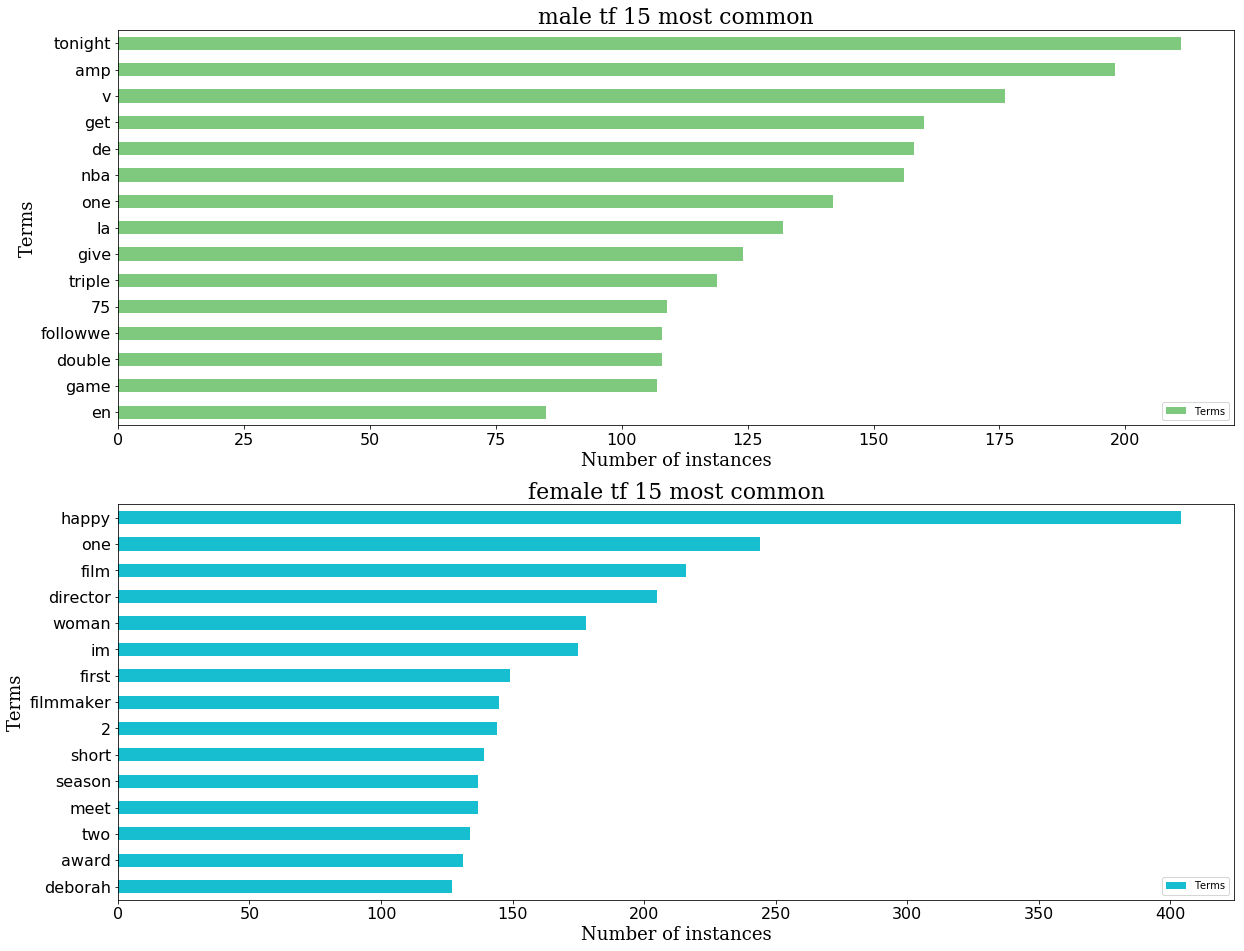

In [70]:
def removePairFromList(lst, el):
    for pair in lst:
        if pair[0] == el:
            lst.remove(pair)

new_twitts_df = extractCleanedDataFromTweets(new_twitts_df)
new_twitts_male_tf = getTfByGender(new_twitts_df, 'male')
new_twitts_female_tf = getTfByGender(new_twitts_df, 'female')
removePairFromList(new_twitts_male_tf, 'rt')
removePairFromList(new_twitts_female_tf, 'rt')

num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(new_twitts_male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(new_twitts_female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### plot for num most common #hashtags

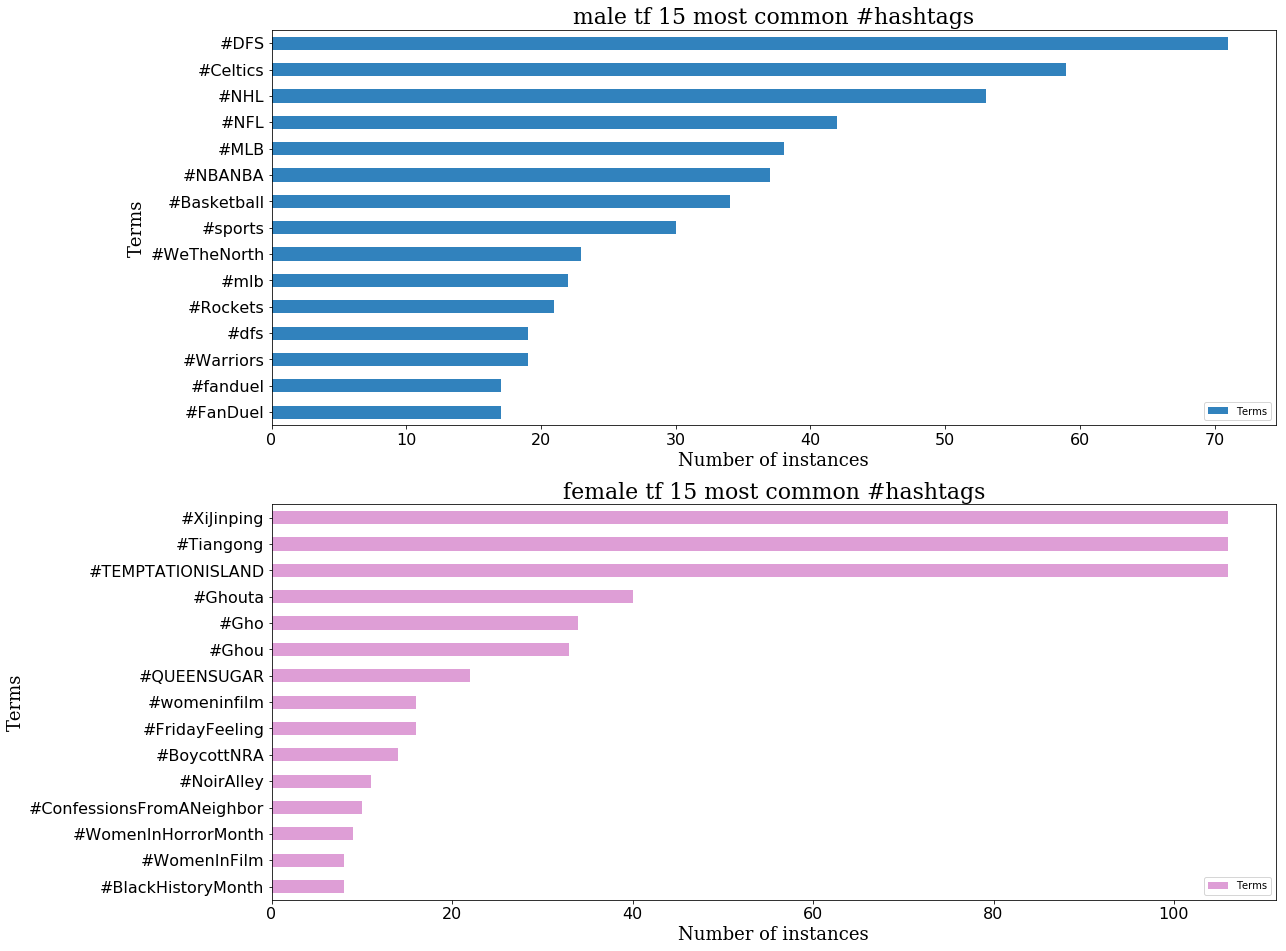

In [73]:
male_hashtag_tf = getHashtagsByGender(new_twitts_df, 'male')
female_hashtag_tf = getHashtagsByGender(new_twitts_df, 'female')
removePairFromList(male_hashtag_tf, '#NBA')
removePairFromList(male_hashtag_tf, '#nba')
removePairFromList(female_hashtag_tf, '#FemaleFilmmakerFriday')
removePairFromList(female_hashtag_tf, '#femalefilmmakerfriday')

num=15
fig = plt.figure(figsize=(18,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')